In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Your existing data loading functions (keeping them as-is)
def stocksData(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        dfTemp = pd.read_csv("data/stock_market_data-{}.csv".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['NaN'])
        dfTemp = dfTemp.rename(columns={'Close': symbol})
        df = df.join(dfTemp)
    return df

def loadData(stock, lookBack):
    data = []
    dataRaw = stock.values
    
    for i in range(len(dataRaw)-lookBack):
        data.append(dataRaw[i: i+lookBack])
        
    data = np.array(data)
    testSize = int(np.round(0.2*data.shape[0]))
    trainSize = data.shape[0]-testSize
    
    X_train = data[:trainSize,:-1,:]
    y_train = data[:trainSize,-1,:]
    X_test = data[trainSize:,:-1,:]
    y_test = data[trainSize:,-1,:]
    
    return X_train, X_test, y_train, y_test

# Enhanced Transformer model for stock prediction
class StockTransformer(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=3, output_dim=1, 
                 max_seq_len=100, dropout=0.1):
        super(StockTransformer, self).__init__()
        
        self.d_model = d_model
        self.input_dim = input_dim
        
        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.pos_encoder = self._create_positional_encoding(max_seq_len, d_model)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layers
        self.dropout = nn.Dropout(dropout)
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, output_dim)
        )
        
    def _create_positional_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Project input to d_model dimensions
        x = self.input_projection(x) * np.sqrt(self.d_model)
        
        # Add positional encoding
        pos_encoding = self.pos_encoder[:, :seq_len, :].to(x.device)
        x = x + pos_encoding
        
        # Apply transformer encoder
        output = self.transformer_encoder(x)
        
        # Use the last time step for prediction
        output = output[:, -1, :]
        
        # Apply dropout and output projection
        output = self.dropout(output)
        output = self.output_projection(output)
        
        return output


Using device: cuda
Training data shape: X_train: (911, 100, 1), y_train: (911, 20)
Test data shape: X_test: (228, 100, 1), y_test: (228, 20)
Model parameters: 5,007,124
Epoch 0: Train Loss: 0.203719, Val Loss: 0.002478
Epoch 20: Train Loss: 0.200507, Val Loss: 0.002795
Epoch 40: Train Loss: 0.187594, Val Loss: 0.003798
Epoch 60: Train Loss: 0.184452, Val Loss: 0.003910
Epoch 80: Train Loss: 0.179581, Val Loss: 0.005218
Epoch 100: Train Loss: 0.178076, Val Loss: 0.005027
Early stopping at epoch 105


/tmp/ipykernel_30844/2107762293.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_multistep_model.pth'))


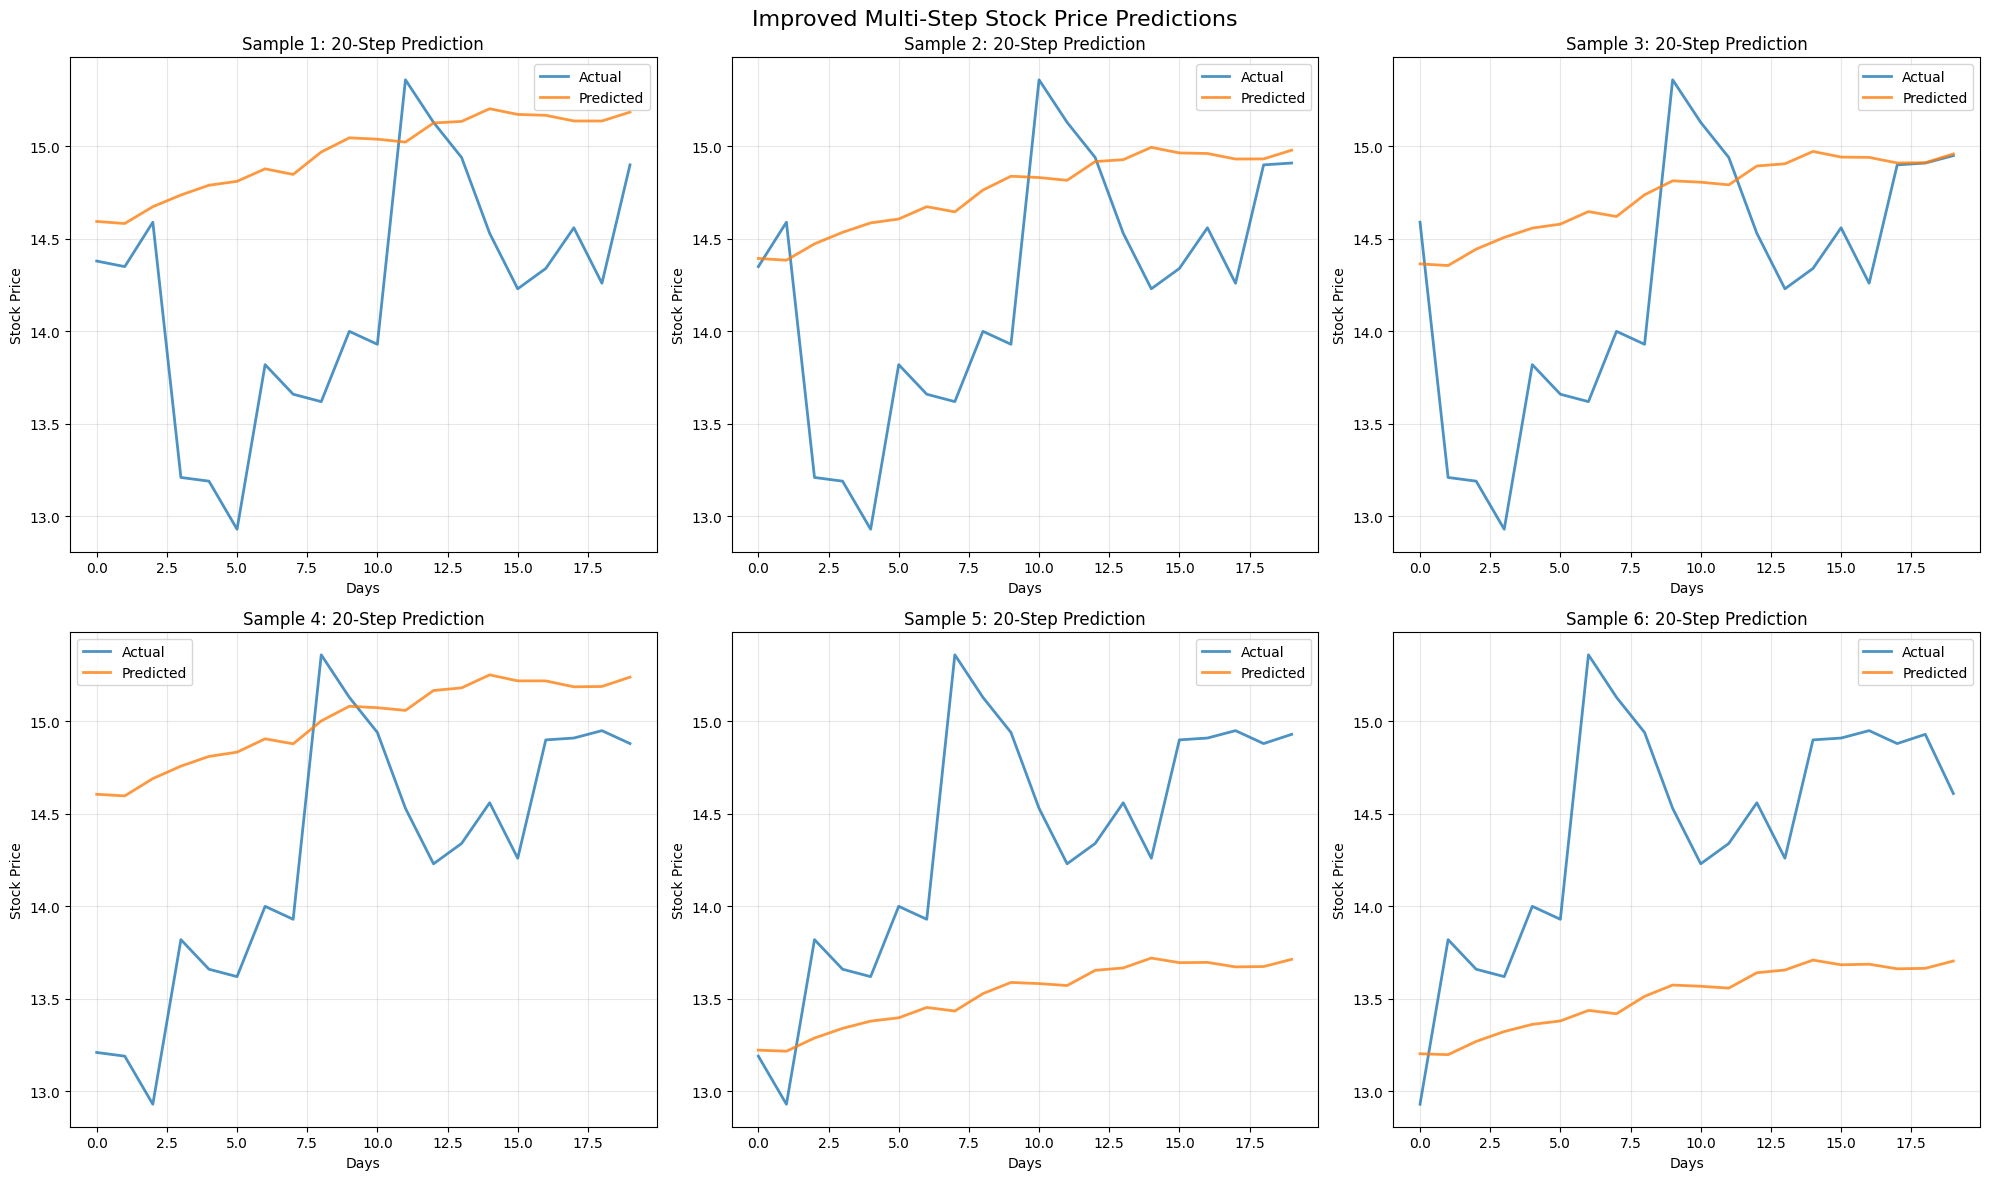


Improved Multi-Step Model Performance:
RMSE: $1.03
MAE: $0.74
MAPE: 5.77%


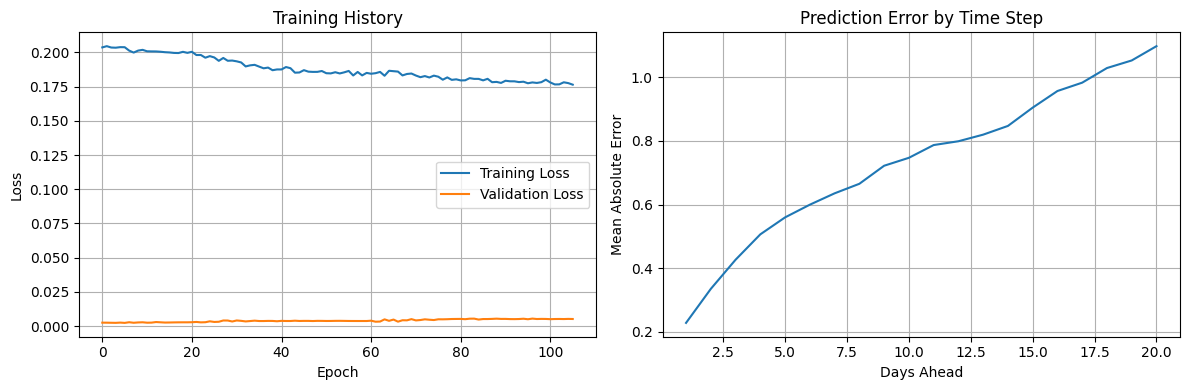

In [10]:

class DirectMultiStepTransformer(nn.Module):
    """
    Direct multi-step prediction transformer - predicts all future steps at once
    """
    def __init__(self, input_dim, d_model=256, nhead=8, num_layers=4, 
                 output_steps=20, max_seq_len=100, dropout=0.1):
        super(DirectMultiStepTransformer, self).__init__()
        
        self.d_model = d_model
        self.output_steps = output_steps
        
        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.pos_encoder = self._create_positional_encoding(max_seq_len, d_model)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            activation='gelu',  # GELU often works better for financial data
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Multi-step output projection
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 2, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, output_steps)  # Direct prediction of all future steps
        )
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
                
    def _create_positional_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Project input
        x = self.input_projection(x) * np.sqrt(self.d_model)
        
        # Add positional encoding
        pos_encoding = self.pos_encoder[:, :seq_len, :].to(x.device)
        x = x + pos_encoding
        
        # Apply transformer
        output = self.transformer_encoder(x)
        
        # Global average pooling over sequence dimension
        output = output.mean(dim=1)  # Better than just using last timestep
        
        # Project to multi-step output
        output = self.output_projection(output)
        
        return output

# Enhanced data loading for multi-step prediction
def create_multistep_data(stock_data, lookback=20, future_steps=20):
    """
    Create proper training data for multi-step prediction
    """
    X, y = [], []
    
    for i in range(len(stock_data) - lookback - future_steps + 1):
        # Input sequence
        sequence = stock_data[i:i + lookback]
        # Future targets (what we want to predict)
        targets = stock_data[i + lookback:i + lookback + future_steps]
        
        X.append(sequence)
        y.append(targets.flatten())  # Flatten to 1D
    
    return np.array(X), np.array(y)

# Constrained prediction to prevent extreme values
class ConstrainedMultiStepTransformer(DirectMultiStepTransformer):
    """
    Transformer with constraints to prevent unrealistic predictions
    """
    def __init__(self, *args, max_daily_change=0.05, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_daily_change = max_daily_change  # Max 5% change per day
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Get last price from input sequence
        last_price = x[:, -1, 0]  # Shape: (batch_size,)
        
        # Standard forward pass
        x_proj = self.input_projection(x) * np.sqrt(self.d_model)
        pos_encoding = self.pos_encoder[:, :seq_len, :].to(x.device)
        x_proj = x_proj + pos_encoding
        
        output = self.transformer_encoder(x_proj)
        output = output.mean(dim=1)
        
        # Predict changes instead of absolute values
        predicted_changes = self.output_projection(output)  # Shape: (batch_size, output_steps)
        
        # Apply sigmoid and scale to reasonable range
        predicted_changes = torch.tanh(predicted_changes) * self.max_daily_change
        
        # Convert changes to absolute prices
        predictions = []
        current_price = last_price
        
        for step in range(self.output_steps):
            change = predicted_changes[:, step]
            current_price = current_price * (1 + change)  # Relative change
            predictions.append(current_price.unsqueeze(1))
        
        return torch.cat(predictions, dim=1)

# Improved training function
def train_multistep_transformer_improved(model, train_loader, val_loader, device, num_epochs=200):
    """
    Enhanced training with better loss function and regularization
    """
    # Combined loss: MSE + directional accuracy
    mse_criterion = nn.MSELoss()
    
    def combined_loss(pred, target):
        # MSE loss
        mse_loss = mse_criterion(pred, target)
        
        # Directional loss (penalize wrong direction predictions)
        pred_direction = torch.sign(pred[:, 1:] - pred[:, :-1])
        target_direction = torch.sign(target[:, 1:] - target[:, :-1])
        direction_loss = torch.mean((pred_direction - target_direction) ** 2)
        
        return mse_loss + 0.1 * direction_loss
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2)
    
    best_val_loss = float('inf')
    patience = 100
    patience_counter = 0
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            
            output = model(data)
            loss = combined_loss(output, target)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += mse_criterion(output, target).item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        scheduler.step()
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_multistep_model.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch}: Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    # Load best model
    model.load_state_dict(torch.load('best_multistep_model.pth'))
    return train_losses, val_losses

# Complete training pipeline
def train_improved_multistep_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load and prepare data (using your existing functions)
    dates = pd.date_range('2020-01-02', '2024-12-31', freq='B')
    symbols = ['AAL']
    df1 = pd.DataFrame(index=dates)
    dfAAL = stocksData(symbols, dates)
    dfAAL = df1.join(dfAAL)
    dfAAL = dfAAL[['AAL']].dropna()
    
    # Normalize data
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    dfAAL_scaled = scaler.fit_transform(dfAAL.values)
    
    # Create multi-step training data
    lookback = 100
    future_steps = 20
    
    X, y = create_multistep_data(dfAAL_scaled, lookback, future_steps)
    
    # Split data
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    print(f"Training data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Test data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    # Convert to tensors
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)
    
    # Create data loaders
    batch_size = 256
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Create constrained model
    model = ConstrainedMultiStepTransformer(
        input_dim=1,
        d_model=256,
        nhead=8,
        num_layers=6,
        output_steps=future_steps,
        max_seq_len=lookback,
        dropout=0.1,
        max_daily_change=0.03  # Max 3% daily change
    ).to(device)
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Train model
    train_losses, val_losses = train_multistep_transformer_improved(
        model, train_loader, test_loader, device, num_epochs=200
    )
    
    # Evaluate model
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test.to(device)).cpu().numpy()
        test_actual = y_test.numpy()
    
    # Inverse transform
    test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1)).reshape(test_predictions.shape)
    test_actual_inv = scaler.inverse_transform(test_actual.reshape(-1, 1)).reshape(test_actual.shape)
    
    # Plot results
    plt.figure(figsize=(20, 12))
    
    # Plot multiple samples
    for i in range(min(6, len(test_predictions_inv))):
        plt.subplot(2, 3, i+1)
        plt.plot(test_actual_inv[i], label='Actual', linewidth=2, alpha=0.8)
        plt.plot(test_predictions_inv[i], label='Predicted', linewidth=2, alpha=0.8)
        plt.title(f'Sample {i+1}: 20-Step Prediction', fontsize=12)
        plt.xlabel('Days')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.suptitle('Improved Multi-Step Stock Price Predictions', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics
    mse = np.mean((test_predictions_inv - test_actual_inv) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(test_predictions_inv - test_actual_inv))
    mape = np.mean(np.abs((test_actual_inv - test_predictions_inv) / test_actual_inv)) * 100
    
    print(f"\nImproved Multi-Step Model Performance:")
    print(f"RMSE: ${rmse:.2f}")
    print(f"MAE: ${mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot prediction accuracy over time steps
    step_errors = np.mean(np.abs(test_predictions_inv - test_actual_inv), axis=0)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, future_steps+1), step_errors)
    plt.title('Prediction Error by Time Step')
    plt.xlabel('Days Ahead')
    plt.ylabel('Mean Absolute Error')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return model, scaler

# Run the improved training
model, scaler = train_improved_multistep_model()